<a href="https://colab.research.google.com/github/yaiza612/Ligand_based_screening/blob/main/Lead_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My aim is create an automated pipeline to lead discovery based in ligand based screening. 
The idea is demonstrate that it is posible retrieve good candidate for inhibit KIT (overexpressed in acute leukemia) using artificial inteligence. 
As well as molecular docking and ADMET screening. 
This has been already done to find new inhibitors against oncoproteins (Baddipadige Raju et al., 2021).
Nevertheless, until nowadays this approach wasn't use yet to retrieve inhibitors against KIT. 


In [ ]:
!pip install rdkit-pypi -qqq
!pip install chembl_webresource_client
!pip install auto-sklearn

     |████████████████████████████████| 20.8 MB 1.5 MB/s 
  Using cached chembl_webresource_client-0.10.7-py3-none-any.whl (55 kB)
  Using cached requests_cache-0.7.5-py3-none-any.whl (39 kB)
     |████████████████████████████████| 60 kB 4.6 MB/s 
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl (6.8 kB)
  Using cached itsdangerous-2.0.1-py3-none-any.whl (18 kB)
     |████████████████████████████████| 661 kB 16.2 MB/s 
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6350 sha256=0cc8509175ea43d5e268423e9ab911f50761270d9c5165e85883ee525ac402b5
  Stored in directory: /root/.cache/pip/wheels/b2/1c/36/fd8efc3fa029b1445d869f359ec13e8fbce7fc9e81505bca66
Successfully built easydict
  Using cached auto-sklearn-0.14.2.tar.gz (6.3 MB)
     |████████████████████████████████| 23.8 MB 1.6 MB/s 
  Using cached dask-2021.6.2-py3-none-any.whl (973 kB)
  Using cached distributed-2021.6.2-py3-none-any.whl (722 kB)
  Using cached liac-arff-2.5.0.tar.gz (13 kB)
     |██████

**RETRIEVING DATA**

In [ ]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
import json
import requests 
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity
# Get target data
uniprot_id = "P10721"
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
targets = pd.DataFrame.from_records(targets)
# print for select single protein, it is the first entry so:
target = targets.iloc[0]
chembl_id = target.target_chembl_id
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)
# convert json to dataframe
bioactivities_df = pd.DataFrame.from_records(bioactivities)
# to assure that all are in the same units we should filter the dataframe in the next steps:
bioactivities_df["units"].unique()
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [ ]:
# this is perfect, there is no non-nM entries
# remove duplicates 
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
# obtain the smiles
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(tqdm(compounds_provider))
compounds_df = pd.DataFrame.from_records(
    compounds,
)
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
compounds_df.dropna(axis=0, how="any", inplace=True)
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)
# Reset row indices
output_df.reset_index(drop=True, inplace=True)

  0%|          | 0/1154 [00:00<?, ?it/s]

In [ ]:
# we can see the result of our dataframe which will be the dataset use in the machine learning screening
print(f"Dataframe with {output_df.shape[0]} entries.")

Dataframe with 1154 entries.


In [ ]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL352308,100.0,nM,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...
1,CHEMBL330863,21.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...
2,CHEMBL124660,170.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...
3,CHEMBL126699,6.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...
4,CHEMBL445636,4.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...


In [ ]:
# calculate pIC50 can be a good idea since is easier to interpret than IC50
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)


In the paper Huy Ngoc Pham et al., 2019, the dataset was divided in inhibitor and not inhibitor, taking the threshold of 10nM for inhibition. This will be helpful when for trying the model of deep learning designed in this paper and for the machine learning aproaches I will also try. 
At the end the best model will be use in the ligand based screening.

---



In [ ]:
# set the threshold in 10 nM for inhibition 
output_df['model'] = np.where(output_df['IC50']>10, 1, 0)

In [ ]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,model
0,CHEMBL352308,100.0,nM,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,7.000000,1
1,CHEMBL330863,21.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,7.677781,1
2,CHEMBL124660,170.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,6.769551,1
3,CHEMBL126699,6.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.221849,0
4,CHEMBL445636,4.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.397940,0


In [ ]:
len(output_df[output_df['model']==0])

992

In [ ]:
len(output_df[output_df['model']==1])

162

In [ ]:
output_df

,molecule_chembl_id,IC50,units,smiles,pIC50,model
0,CHEMBL352308,100.0,nM,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,7.000000,0
1,CHEMBL330863,21.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,7.677781,0
2,CHEMBL124660,170.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,6.769551,0
3,CHEMBL126699,6.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.221849,1
4,CHEMBL445636,4.0,nM,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.397940,1
...,...,...,...,...,...,...
1149,CHEMBL4645353,1306.0,nM,O=C(Nc1ccc(Oc2ccnc3[nH]ccc23)c(F)c1)c1cn(-c2cc...,5.884057,0
1150,CHEMBL4640601,910.0,nM,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(OC4CCN(C)CC4)...,6.040959,0
1151,CHEMBL4634073,20.0,nM,COC(=O)Nc1ccc(-c2c(OC3CCN(C)CC3)nc3c(-c4ccc(OC...,7.698970,0
1152,CHEMBL4636995,1600.0,nM,COc1ccc(-c2cnn3c(N)c(-c4nccs4)c(OC4CCN(C)CC4)n...,5.795880,0


DIFFERENT MACHINE LEARNING AND DEEP LEARNING APPROACHES

First I will try different approaches like in Baddipadige Raju (2021).

**Neural network with Keras**

In [ ]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from tensorflow import keras
# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [ ]:
# Keep necessary columns

output_df['labels'] =np.where(output_df['pIC50']>6.3, 1, 0) # inhibitor=1, else 0
chembl_df = output_df[["smiles", "pIC50", "labels"]]
chembl_df.head()

,smiles,pIC50,labels
0,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,7.000000,1
1,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,7.677781,1
2,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,6.769551,1
3,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.221849,1
4,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.397940,1


In [ ]:
# We should convert the smiles to numerical data that can be interpret for the neural network. 
# We can convert the smiles to fingerprints.
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)

In [ ]:
# We should convert the smiles to numerical data that can be interpret for the neural network. 
# We can convert the smiles to fingerprints.
def smiles_to_fp_multiple_support(smiles, methods=["maccs", "morgan2", "morgan3"], n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
    fingerprints = []
    for method in methods:
      if method == "maccs":
          fingerprints.append(np.array(MACCSkeys.GenMACCSKeys(mol)))
      elif method == "morgan2":
          fingerprints.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)))
      elif method == "morgan3":
          fingerprints.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits)))
      else:
          print(f"Warning: Wrong method specified: {method}.")
          raise ValueError
    return np.hstack(fingerprints)
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp_multiple_support)

In [ ]:
(np.array(chembl_df["fingerprints_df"])).shape

(1154,)

In [ ]:
chembl_df.head()

,smiles,pIC50,labels,fingerprints_df
0,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,7.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,7.677781,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,6.769551,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.221849,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.397940,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Now it is neccesary split the data: 
# Next, we define , the features, and , the target data which will be used to train the model. 
# In our case, features are the bit vectors and the target values are the model values (inhibition or not) 
# of the molecules.
# It is possible also use the pIC50 value, and we can try this later on to see if the results are actually better
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50", "labels"]], test_size=0.3, random_state=42
)
y_train_class_labels = y_train[["labels"]]
y_test_class_labels = y_test[["labels"]]
y_train = y_train[["pIC50"]]
y_test = y_test[["pIC50"]]

In [ ]:
# define the neural network
def neural_network_model(hidden1, hidden2, init_lr):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.
    
    init_lr: float
        The initial learning rate
    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    opt = keras.optimizers.Adam(learning_rate=init_lr)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mse", "mae"])
    return model

Training the model

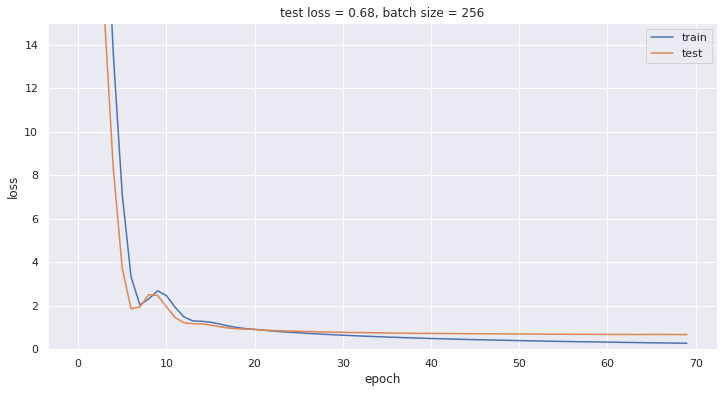

In [ ]:
# Neural network parameters
batch_sizes = 256
nb_epoch = 70
layer1_size = 24
layer2_size = 12
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)


model = neural_network_model(layer1_size, layer2_size, 0.001)

# Fit model on x_train, y_train data
history = model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    batch_size=batch_sizes,
    validation_data=(np.array(list((x_test))).astype(float), y_test.values),
    verbose=0,
    epochs=nb_epoch,
)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend(["train", "test"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim((0, 15))
plt.title(
    f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch_sizes}"
)
plt.show()

In [ ]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.68
 mse (same as loss): 0.68
 mae: 0.63


In [ ]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

7.62
7.07
7.26
6.59
6.12


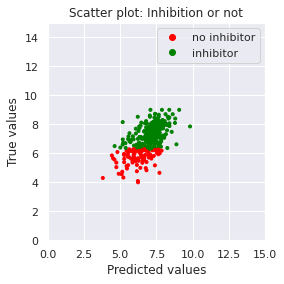

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
colors = ['red','green']
legend_labels = ["no inhibitor", "inhibitor"]
scatter = ax.scatter(y_pred, y_test, marker=".", c=y_test_class_labels.values, cmap=matplotlib.colors.ListedColormap(colors))
lin = np.linspace(*limits, 100)
#ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: Inhibition or not")
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

The fit is obviusly not perfect, for this reason I will try the model presented in the paper Huy Ngoc Pham et al., 2019.

**MACHINE LEARNING APPROACHES**

In [ ]:
# Definition of helper functions
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [ ]:
chembl_df

,smiles,pIC50,model,fingerprints_df
0,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,7.000000,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,7.677781,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,6.769551,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.221849,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8.397940,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
1149,O=C(Nc1ccc(Oc2ccnc3[nH]ccc23)c(F)c1)c1cn(-c2cc...,5.884057,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1150,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(OC4CCN(C)CC4)...,6.040959,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1151,COC(=O)Nc1ccc(-c2c(OC3CCN(C)CC3)nc3c(-c4ccc(OC...,7.698970,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1152,COc1ccc(-c2cnn3c(N)c(-c4nccs4)c(OC4CCN(C)CC4)n...,5.795880,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# again split the data 
fingerprint_to_model = chembl_df.fingerprints_df.tolist()
label_to_model = chembl_df.model.tolist()
SEED = 22
# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 923
Test data size: 231


In [ ]:
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

LOGISTIC REGRESSION


In [ ]:
# Set model parameter for Logistic Regression
model_LR = LogisticRegression()
# Fit model on single split
performance_measures = model_training_and_validation(model_LR, "LR", splits)

Sensitivity: 0.14
Specificity: 0.96
AUC: 0.72


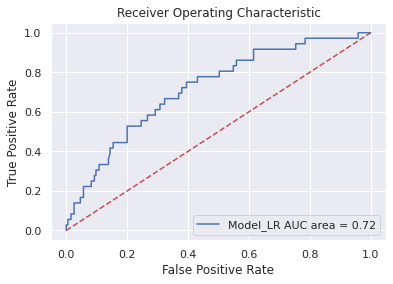

In [ ]:
# Initialize the list that stores all models. First one is LR.
models = [{"label": "Model_LR", "model": model_LR}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

RANDOM FOREST CLASSIFIER

In [ ]:
# Set model parameter for random forest
param = {
    "n_estimators": 1000,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.36
Specificity: 0.96
AUC: 0.74


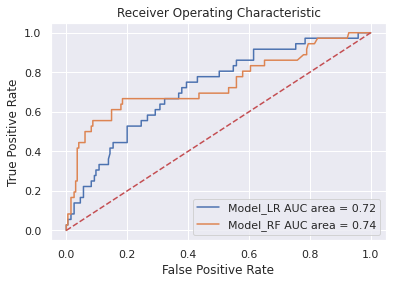

In [ ]:
# Initialize the list that stores all models. First one is RF.
models.append({"label": "Model_RF", "model": model_RF})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

SUPPORT VECTOR MACHINE

In [ ]:
# Specify model
model_SVM = svm.SVC(kernel="poly", C=10, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

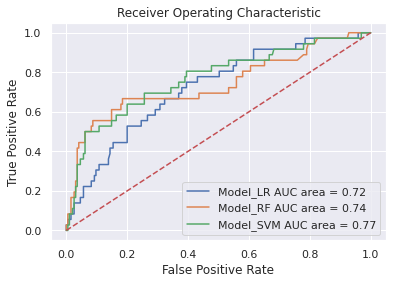

In [ ]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

MULTILAYER PERCEPTRON CLASSIFIER

In [ ]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(64, 32), batch_size=64, learning_rate="adaptive", learning_rate_init=0.001, random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.42
Specificity: 0.93
AUC: 0.74


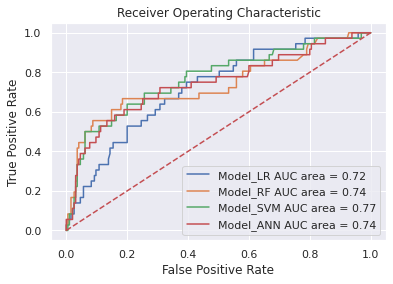

In [ ]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

In [ ]:
# I should perform a cross validation
import time
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fingerprints_df.tolist()
        train_y = df.iloc[train_index].model.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fingerprints_df.tolist()
        test_y = df.iloc[test_index].model.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [ ]:
N_FOLDS = 5
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], chembl_df, n_folds=N_FOLDS)


Model_LR
Mean accuracy: 0.85 	and std : 0.02 
Mean sensitivity: 0.20 	and std : 0.06 
Mean specificity: 0.96 	and std : 0.01 
Mean AUC: 0.78 	and std : 0.04 
Time taken : 0.44s


Model_RF
Mean accuracy: 0.89 	and std : 0.02 
Mean sensitivity: 0.43 	and std : 0.05 
Mean specificity: 0.96 	and std : 0.01 
Mean AUC: 0.78 	and std : 0.03 
Time taken : 13.45s


Model_SVM
Mean accuracy: 0.88 	and std : 0.03 
Mean sensitivity: 0.26 	and std : 0.09 
Mean specificity: 0.98 	and std : 0.01 
Mean AUC: 0.78 	and std : 0.01 
Time taken : 2.22s


Model_ANN
Mean accuracy: 0.85 	and std : 0.02 
Mean sensitivity: 0.38 	and std : 0.10 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.77 	and std : 0.04 
Time taken : 3.96s



The models does not have as good accuraccy as I would like to see. So I researched papers and came across the following paper (Huy Ngoc Pham et al., 2019) (Attention-based Multi-Input Deep Learning
Architecture for Biological Activity Prediction:
An Application in EGFR Inhibitors), which achieved a new state of the art for a very similar problem. For that reason, I adopt their method and use their code to implement a neural network with attention. 

This is their code: https://github.com/lehgtrung/egfr-att

In [ ]:
mols = [Chem.MolFromSmiles(i) for i in output_df.smiles]

The following code blocks are from their git repository. 

In [ ]:
!pip install mordred
from mordred import Calculator, descriptors
from rdkit.Chem import rdchem
calc = Calculator(descriptors, ignore_3D=True)
#md = calc.pandas(mols)
import re

Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

#
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)

def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)

def calc_featurevector(mol, smiles,atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize)

#smile_ft = [mol_to_feature(mol,-1, 150) for mol in mols]
#md['active'] = output_df.model
#md['smile'] = output_df.smiles
#md['smile_ft'] = smile_ft
#md.head()

     |████████████████████████████████| 128 kB 5.0 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=78d7c725be3d0d3b4486ce45a8317f364f07e96eb54e63931fb92b04e28a8086
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [ ]:
NON_MORD_NAMES = ['smile_ft', 'smile', 'active']
mord_ft = md.drop(columns=NON_MORD_NAMES).astype(np.float64).dropna(axis=1)

columns_1 = md.columns.tolist()
columns_2 = mord_ft.columns.tolist()
for ele_1, ele_2 in zip(columns_1, columns_2):
  if not ele_1 == ele_2:
    print(ele_1, ele_2)
    break

print(len(columns_1))

print(len(columns_2))

SpAbs_A nAromAtom
1616
1162


In [ ]:
scl = StandardScaler()
a = scl.fit_transform(md.drop(columns=NON_MORD_NAMES).astype(np.float64).dropna(axis=1)).tolist()

In [ ]:
md_solved = md.drop(columns='AXp-0dv') 
len(md_solved.columns)


1615

In [ ]:
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

class EGFRDataset(data.Dataset):
    def __init__(self, data, infer=False, use_labels= True):
        if isinstance(data, pd.DataFrame):
            self.data = data
        elif isinstance(data, str):
            self.data = read_data(data)
        self.use_labels = use_labels
        if self.use_labels:
          self.NON_MORD_NAMES = ['smile_ft', 'smile', 'active']
        else:
          self.NON_MORD_NAMES = ['smile_ft', 'smile']
        self.infer = infer
        

        # Standardize mord features
        scl = StandardScaler()
        #self.mord_ft = self.data.drop(columns=self.NON_MORD_NAMES).astype(np.float64).dropna(axis=1)
        self.mord_ft = scl.fit_transform(self.data.drop(columns=self.NON_MORD_NAMES).astype(np.float64).dropna(axis=1)).tolist()

        self.non_mord_ft = self.data['smile_ft'].values.tolist()
        self.smiles = self.data['smile'].values.tolist()
        if self.use_labels:
          self.label = self.data['active'].values.tolist()
        else:
          self.label = None



    def __len__(self):
      if not self.use_labels:
          return len(self.label)
      else:
          print("length cannot be computed")


    def __getitem__(self, idx):
      if self.use_labels:
        return self.smiles[idx], self.mord_ft[idx], self.non_mord_ft[idx]
      else:
        if self.infer:
            return self.smiles[idx], self.mord_ft[idx], self.non_mord_ft[idx], self.label[idx]
        else:
            return self.mord_ft[idx], self.non_mord_ft[idx], self.label[idx]

    def get_dim(self, ft):
        if ft == 'non_mord':
            return len(self.non_mord_ft[0])
        if ft == 'mord':
            return len(self.mord_ft[0])

    def get_smile_ft(self):
        return self.non_mord_ft

import os
import pickle
import torch


def get_max_length(x):
    return len(max(x, key=len))


def pad_sequence(seq):
    def _pad(_it, _max_len):
        return [0] * (_max_len - len(_it)) + _it
    padded = [_pad(it, get_max_length(seq)) for it in seq]
    return padded


def custom_collate(batch):
    transposed = zip(*batch)
    lst = []
    for samples in transposed:
        try:
            if isinstance(samples[0], str) or isinstance(samples[0], unicode):
                lst.append(samples)
        except NameError:
            if isinstance(samples[0], str):
                lst.append(samples)
        if isinstance(samples[0], int):
            lst.append(torch.LongTensor(samples))
        elif isinstance(samples[0], float):
            lst.append(torch.DoubleTensor(samples))
        elif isinstance(samples[0], list):
            lst.append(torch.LongTensor(pad_sequence(samples)))
    return lst


def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


def save_model(model, model_dir_path, hash_code):
    if not os.path.exists(model_dir_path):
        os.makedirs(model_dir_path)
    torch.save(model.state_dict(), "{}/model_{}_{}".format(model_dir_path, hash_code, "BEST"))
    print('Save done!')


import torch
import torch.nn as nn
import torch.nn.functional as F
import os


class UnitedNet(nn.Module):
    def __init__(self, dense_dim, use_mord=True, use_mat=True, infer=False, dir_path=None, vis_thresh=0.2):
        super(UnitedNet, self).__init__()
        self.use_mord = use_mord
        self.use_mat = use_mat
        self.infer = infer
        self.vis_thresh = vis_thresh
        self.dir_path = dir_path
        if self.dir_path:
            self.smile_out_f = open(os.path.join(self.dir_path, 'smiles.txt'), 'w')
            self.weight_f = open(os.path.join(self.dir_path, 'weight.txt'), 'w')

        # PARAMS FOR CNN NET
        # Convolutionals
        self.conv_conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.conv_pool = nn.MaxPool2d(2, 2)
        self.conv_conv2 = nn.Conv2d(6, 16, kernel_size=3)

        # Fully connected
        self.conv_fc = nn.Linear(16 * 9 * 36, 150)

        # Batch norms
        self.conv_batch_norm1 = nn.BatchNorm2d(6)
        self.conv_batch_norm2 = nn.BatchNorm2d(16)

        # PARAMS FOR DENSE NET
        # Fully connected
        if self.use_mord:
            self.dense_fc1 = nn.Linear(dense_dim, 512)
            self.dense_fc2 = nn.Linear(512, 128)
            self.dense_fc3 = nn.Linear(128, 64)

            # Batch norms
            self.dense_batch_norm1 = nn.BatchNorm1d(512)
            self.dense_batch_norm2 = nn.BatchNorm1d(128)
            self.dense_batch_norm3 = nn.BatchNorm1d(64)

            # Dropouts
            self.dense_dropout = nn.Dropout()

        # PARAMS FOR ATTENTION NET
        if self.use_mat:
            self.att_fc = nn.Linear(256, 1)
        else:
            self.comb_fc_alt = nn.Linear(128, 1)

        # PARAMS FOR COMBINED NET
        if self.use_mord:
            self.comb_fc = nn.Linear(214, 1)
        else:
            self.comb_fc = nn.Linear(150, 1)

    def forward(self, x_non_mord, x_mord, x_mat, smiles=None):
        # FORWARD CNN
        x_non_mord = self.conv_conv1(x_non_mord)
        x_non_mord = self.conv_batch_norm1(x_non_mord)
        x_non_mord = F.relu(x_non_mord)
        x_non_mord = self.conv_pool(x_non_mord)

        x_non_mord = self.conv_conv2(x_non_mord)
        x_non_mord = self.conv_batch_norm2(x_non_mord)
        x_non_mord = F.relu(x_non_mord)
        x_non_mord = self.conv_pool(x_non_mord)

        x_non_mord = x_non_mord.view(x_non_mord.size(0), -1)
        if self.use_mat:
            x_non_mord = F.sigmoid(self.conv_fc(x_non_mord))
        else:
            x_non_mord = F.relu(self.conv_fc(x_non_mord))

        # FORWARD DENSE
        if self.use_mord:
            x_mord = F.relu(self.dense_fc1(x_mord))
            x_mord = self.dense_batch_norm1(x_mord)
            x_mord = self.dense_dropout(x_mord)

            x_mord = F.relu(self.dense_fc2(x_mord))
            x_mord = self.dense_batch_norm2(x_mord)
            x_mord = self.dense_dropout(x_mord)

            x_mord = F.relu(self.dense_fc3(x_mord))
            x_mord = self.dense_batch_norm3(x_mord)
            x_mord = self.dense_dropout(x_mord)

        # FORWARD ATTENTION
        if self.use_mat:
            x_mat = torch.bmm(x_mat.permute(0, 2, 1), x_non_mord.unsqueeze(-1)).squeeze(-1)
            x_mat = torch.cat([x_mat, x_non_mord], dim=1)

            if self.use_mord:
                x_comb = torch.cat([x_mat, x_mord], dim=1)
                probs = torch.sigmoid(self.att_fc(x_comb))
                if self.infer:
                    if not smiles:
                        raise ValueError('Please input smiles')
                    alphas = x_comb.cpu().detach().numpy().tolist()
                    alphas = ["\t".join([str(round(elem, 4)) for elem in seq]) for seq in alphas]
                    prob_list = probs.cpu().detach().numpy().tolist()
                    for smile, alpha, prob in zip(smiles, alphas, prob_list):
                        if prob[0] > self.vis_thresh:
                            self.weight_f.write(alpha + '\n')
                            self.smile_out_f.write(smile + '\n')
                return probs
            else:
                return torch.sigmoid(self.comb_fc(x_mat))
        else:
            if self.use_mord:
                x_comb = torch.cat([x_non_mord, x_mord], dim=1)
            else:
                x_comb = x_non_mord
            return torch.sigmoid(self.comb_fc(x_comb))

    def __del__(self):
        print('Closing files ...')
        if hasattr(self, 'weight_f'):
            self.weight_f.close()
        if hasattr(self, 'smile_out_f'):
            self.smile_out_f.close()

In [ ]:
import numpy as np
train_data, val_data = train_test_split(md_solved, test_size=0.2, random_state=42)
train_dataset = EGFRDataset(train_data)
val_dataset = EGFRDataset(val_data)

In [ ]:
columns_1 = train_dataset.mord_ft.columns.tolist()
columns_2 = val_dataset.mord_ft.columns.tolist()
for ele_1, ele_2 in zip(columns_1, columns_2):
  if not ele_1 == ele_2:
    print(ele_1, ele_2)
    break

Xp-0dv Xp-1dv


In [ ]:
train_dataset.get_dim('mord')

1163

In [ ]:
val_dataset.get_dim('mord')

1163

In [ ]:
len(train_dataset.mord_ft[0])

1163

In [ ]:
len(val_dataset.mord_ft[0])

1163

In [ ]:
len(train_dataset.non_mord_ft)

923

In [ ]:
len(val_dataset.non_mord_ft)

231

In [ ]:
len(train_dataset.smiles)

923

In [ ]:
len(val_dataset.smiles)

231

In [ ]:
len(train_dataset.label)

923

In [ ]:
len(val_dataset.label)

231

In [ ]:
!pip install tensorboard_logger

In [ ]:
import numpy as np
import sklearn.metrics as metrics
THRESH = 0.8


def auc(y_true, y_scores):
    y_true = y_true.cpu().detach().numpy()
    y_scores = y_scores.cpu().detach().numpy()
    return metrics.roc_auc_score(y_true, y_scores)


def auc_threshold(y_true, y_scores):
    y_true = y_true.cpu().detach().numpy()
    y_scores = y_scores.cpu().detach().numpy()
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_scores)
    return metrics.auc(fpr, tpr)


def get_score_obj(y_true, y_scores, thresh=THRESH):
    y_true = y_true.cpu().detach().numpy()
    y_scores = (y_scores.cpu().detach().numpy() + thresh).astype(np.int16)
    return metrics.classification_report(y_true, y_scores, output_dict=True)


def f1(y_true, y_scores):
    score_obj = get_score_obj(y_true, y_scores)
    return score_obj['weighted avg']['f1-score']

# Metrics for benchmark


def sensitivity(y_true, y_scores, thresh=THRESH):
    y_true = y_true.cpu().detach().numpy()
    y_scores = (y_scores.cpu().detach().numpy() + 1 - thresh).astype(np.int16)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores).ravel()
    return tp / (tp + fn)


def specificity(y_true, y_scores, thresh=THRESH):
    y_true = y_true.cpu().detach().numpy()
    y_scores = (y_scores.cpu().detach().numpy() + 1 - thresh).astype(np.int16)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores).ravel()
    return tn / (tn + fp)


def accuracy(y_true, y_scores, thresh=THRESH):
    y_true = y_true.cpu().detach().numpy()
    y_scores = (y_scores.cpu().detach().numpy() + 1 - thresh).astype(np.int16)
    return metrics.accuracy_score(y_true, y_scores)


def mcc(y_true, y_scores, thresh=THRESH):
    y_true = y_true.cpu().detach().numpy()
    y_scores = (y_scores.cpu().detach().numpy() + 1 - thresh).astype(np.int16)
    return metrics.matthews_corrcoef(y_true, y_scores)

# METRICS FOR CV


def auc_cv(y_true, y_scores):
    return metrics.roc_auc_score(y_true, y_scores)


def get_score_obj_cv(y_true, y_scores, thresh=THRESH):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores = (y_scores + 1 - thresh).astype(np.int16)
    return metrics.classification_report(y_true, y_scores, output_dict=True)


def f1_cv(y_true, y_scores):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    score_obj = get_score_obj_cv(y_true, y_scores)
    return score_obj['weighted avg']['f1-score']


def class1_precision_cv(y_true, y_scores):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    score_obj = get_score_obj_cv(y_true, y_scores)
    return score_obj['1.0']['precision']


def class1_recall_cv(y_true, y_scores):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    score_obj = get_score_obj_cv(y_true, y_scores)
    return score_obj['1.0']['recall']


def sensitivity_cv(y_true, y_scores, thresh=THRESH):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores = (y_scores + 1 - thresh).astype(np.int16)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores).ravel()
    return tp / (tp + fn)


def specificity_cv(y_true, y_scores, thresh=THRESH):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores = (y_scores + 1 - thresh).astype(np.int16)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores).ravel()
    return tn / (tn + fp)


def accuracy_cv(y_true, y_scores, thresh=THRESH):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores = (y_scores + 1 - thresh).astype(np.int16)
    return metrics.accuracy_score(y_true, y_scores)


def mcc_cv(y_true, y_scores, thresh=THRESH):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores = (y_scores + 1 - thresh).astype(np.int16)
    return metrics.matthews_corrcoef(y_true, y_scores)


In [ ]:
train_dataset.get_dim('mord')-1

1163

In [ ]:
import argparse
import torch
import torch.nn as nn
import tensorboard_logger
from torch.utils.data import dataloader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.metrics import precision_recall_curve
plt.switch_backend('agg')
warnings.filterwarnings('ignore')


def train_validate_united(train_dataset,
                          val_dataset,
                          train_device,
                          val_device,
                          use_mat,
                          use_mord,
                          opt_type,
                          n_epoch,
                          batch_size,
                          metrics,
                          hash_code,
                          lr):
    train_loader = dataloader.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         collate_fn=custom_collate,
                                         shuffle=False)

    val_loader = dataloader.DataLoader(dataset=val_dataset,
                                       batch_size=batch_size,
                                       collate_fn=custom_collate,
                                       shuffle=False)

    #tensorboard_logger.configure('logs/' + hash_code)
    f= open("/content/drive/My Drive/Discovery_Data/data_model.txt","w+")

    criterion = nn.BCELoss()
    united_net = UnitedNet(dense_dim=train_dataset.get_dim('mord'),
                           use_mat=use_mat, use_mord=use_mord).to(train_device)

    if opt_type == 'sgd':
        opt = optim.SGD(united_net.parameters(),
                        lr=lr,
                        momentum=0.99)
    elif opt_type == 'adam':
        opt = optim.Adam(united_net.parameters(),
                         lr=lr)

    min_loss = 100  # arbitary large number
    early_stop_count = 0
    for e in range(n_epoch):
        train_losses = []
        val_losses = []
        train_outputs = []
        val_outputs = []
        train_labels = []
        val_labels = []
        print(e, '--', 'TRAINING ==============>')
        for i, (mord_ft, non_mord_ft, label) in enumerate(train_loader):
            united_net.train()
            mord_ft = mord_ft.float().to(train_device)
            non_mord_ft = non_mord_ft.view((-1, 1, 150, 42)).float().to(train_device)
            mat_ft = non_mord_ft.squeeze(1).float().to(train_device)
            label = label.float().to(train_device)
            label = label[:, None]

            # Forward
            opt.zero_grad()
            outputs = united_net(non_mord_ft, mord_ft, mat_ft)

            loss = criterion(outputs, label)
            train_losses.append(float(loss.item()))
            train_outputs.extend(outputs)
            train_labels.extend(label)

            # Parameters update
            loss.backward()
            opt.step()

        # Validate after each epoch
        print('EPOCH', e, '--', 'VALIDATION ==============>')
        for i, (mord_ft, non_mord_ft, label) in enumerate(val_loader):
            united_net.eval()
            mord_ft = mord_ft.float().to(val_device)
            non_mord_ft = non_mord_ft.view((-1, 1, 150, 42)).float().to(val_device)
            mat_ft = non_mord_ft.squeeze(1).float().to(train_device)
            label = label.float().to(val_device)
            label = label[:, None]

            with torch.no_grad():
                print(non_mord_ft.shape, mord_ft.shape, mat_ft.shape )
                outputs = united_net(non_mord_ft, mord_ft, mat_ft)

                loss = criterion(outputs, label)
                val_losses.append(float(loss.item()))
                val_outputs.extend(outputs)
                val_labels.extend(label)

        train_outputs = torch.stack(train_outputs)
        val_outputs = torch.stack(val_outputs)
        train_labels = torch.stack(train_labels)
        val_labels = torch.stack(val_labels)
        #tensorboard_logger.log_value('train_loss', sum(train_losses) / len(train_losses), e + 1)
        #tensorboard_logger.log_value('val_loss', sum(val_losses) / len(val_losses), e + 1)
        f.write('{"metric": "train_loss", "value": %f, "epoch": %d}' % (sum(train_losses) / len(train_losses), e + 1))
        f.write('{"metric": "val_loss", "value": %f, "epoch": %d}' % (sum(val_losses) / len(val_losses), e + 1))
        print('{"metric": "train_loss", "value": %f, "epoch": %d}' % (sum(train_losses) / len(train_losses), e + 1))
        print('{"metric": "val_loss", "value": %f, "epoch": %d}' % (sum(val_losses) / len(val_losses), e + 1))
        for key in metrics.keys():
            train_metric = metrics[key](train_labels, train_outputs)
            val_metric = metrics[key](val_labels, val_outputs)
            f.write('{"metric": "%s", "value": %f, "epoch": %d}' % ('train_' + key, train_metric, e + 1))
            f.write('{"metric": "%s", "value": %f, "epoch": %d}' % ('val_' + key, val_metric, e + 1))
            print('{"metric": "%s", "value": %f, "epoch": %d}' % ('train_' + key, train_metric, e + 1))
            print('{"metric": "%s", "value": %f, "epoch": %d}' % ('val_' + key, val_metric, e + 1))
            #tensorboard_logger.log_value('train_{}'.format(key),
                                         #train_metric, e + 1)
            #tensorboard_logger.log_value('val_{}'.format(key),
                                         #val_metric, e + 1)
        loss_epoch = sum(val_losses) / len(val_losses)
        if loss_epoch < min_loss:
            early_stop_count = 0
            min_loss = loss_epoch
            save_model(united_net, "/content/drive/My Drive/Discovery_Data/", hash_code + "_{}".format(e))
        else:
            early_stop_count += 1
            if early_stop_count > 30:
                print('Traning can not improve from epoch {}\tBest loss: {}'.format(e, min_loss))
                break

    train_metrics = {}
    val_metrics = {}
    for key in metrics.keys():
        train_metrics[key] = metrics[key](train_labels, train_outputs)
        val_metrics[key] = metrics[key](val_labels, val_outputs)
    
    f.close()

    return train_metrics, val_metrics


def predict(dataset, model_path, device='cpu'):
    loader = dataloader.DataLoader(dataset=dataset,
                                   batch_size=128,
                                   collate_fn=custom_collate,
                                   shuffle=False)
    united_net = UnitedNet(dense_dim=dataset.get_dim('mord'), use_mat=True).to(device)
    united_net.load_state_dict(torch.load(model_path, map_location=device))
    # EVAL_MODE
    united_net.eval()
    probas = []
    for i, (smiles, mord_ft, non_mord_ft) in enumerate(loader):
        with torch.no_grad():
            mord_ft = mord_ft.float().to(device)
            non_mord_ft = non_mord_ft.view((-1, 1, 150, 42)).float().to(device)
            mat_ft = non_mord_ft.squeeze(1).float().to(device)
            # Forward to get smiles and equivalent weights
            proba = united_net(non_mord_ft, mord_ft, mat_ft)
            probas.append(proba)
    print('Forward done !!!')
    probas = np.concatenate(probas)
    return probas


def plot_roc_curve(y_true, y_pred, hashcode=''):

    if not os.path.exists('vis/'):
        os.makedirs('vis/')

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc_roc = metrics.roc_auc_score(y_true, y_pred)
    print('AUC: {:4f}'.format(auc_roc))
    plt.plot(fpr, tpr)
    plt.savefig('vis/ROC_{}'.format(hashcode + '.png'))
    plt.clf()  # Clear figure


def plot_precision_recall(y_true, y_pred, hashcode=''):

    if not os.path.exists('vis/'):
        os.makedirs('vis/')

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.savefig('vis/PR_{}'.format(hashcode + '.png'))
    plt.clf()  # Clear figure


def run_model(train_dataset, val_dataset):
    #parser.add_argument('-g', '--gpu', help='Use GPU or Not?', action='store_true')
    model_path= "/content/drive/My Drive/Discovery_Data/"
    epochs = 500
    batchsize = 128
    opt = 'adam'
    hashcode = 'TEST'
    lr = 1e-5
    mode = 'train'
    use_mat = True
    use_mord = True

    if torch.cuda.is_available():
        train_device = 'cuda'
        val_device = 'cuda'
    else:
        train_device = 'cpu'
        val_device = 'cpu'

    if mode == 'train':
        train_validate_united(train_dataset,
                              val_dataset,
                              train_device,
                              val_device,
                              use_mat,
                              use_mord,
                              opt,
                              int(epochs),
                              int(batchsize),
                              {'sensitivity': sensitivity, 'specificity': specificity,
                               'accuracy': accuracy, 'mcc': mcc, 'auc': auc},
                              hashcode,
                              lr)
    else:
        pred_dataset = EGFRDataset(dataset)
        y_pred = predict(pred_dataset, model_path, train_device)
        y_true = pred_dataset.label

        plot_roc_curve(y_true, y_pred, model_path.split('/')[-1])
        plot_precision_recall(y_true, y_pred, model_path.split('/')[-1])


In [ ]:
run_model(train_dataset, val_dataset)

Streaming output truncated to the last 5000 lines.
{"metric": "val_auc", "value": 0.514251, "epoch": 10}
Save done!
10 -- TRAINING ==============>
EPOCH 10 -- VALIDATION ==============>
torch.Size([128, 1, 150, 42]) torch.Size([128, 1163]) torch.Size([128, 150, 42])
torch.Size([103, 1, 150, 42]) torch.Size([103, 1163]) torch.Size([103, 150, 42])
{"metric": "train_loss", "value": 0.407956, "epoch": 11}
{"metric": "val_loss", "value": 0.381121, "epoch": 11}
{"metric": "train_sensitivity", "value": 0.000000, "epoch": 11}
{"metric": "val_sensitivity", "value": 0.000000, "epoch": 11}
{"metric": "train_specificity", "value": 1.000000, "epoch": 11}
{"metric": "val_specificity", "value": 1.000000, "epoch": 11}
{"metric": "train_accuracy", "value": 0.854821, "epoch": 11}
{"metric": "val_accuracy", "value": 0.878788, "epoch": 11}
{"metric": "train_mcc", "value": 0.000000, "epoch": 11}
{"metric": "val_mcc", "value": 0.000000, "epoch": 11}
{"metric": "train_auc", "value": 0.545306, "epoch": 11}
{"

This is defenetively a good result, 87% of accuracy. I will use this model to predict new inhibitors for cKIT.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LIGAND BASED SCREENING

The next step is use the best model to do a classification with an unknown screening dataset to predict novel potential inhibitors

My original idea was take the full database of molport (around 8 millions of molecules) but the problem is that the calculation of the molecular descriptors take 12 min for every 1000 compounds, and that it is equivalent to 1600 hours in Google Collab, with a longer deadline or a best machine could be possible. 
Taking in a account the short deadline of the assigment, I select Kinase screening library(KSL) from LIFE CHEMICALS to realize the deep learning with attention ligand based screening. KSL was designed based on about 1,000 Markush structures and pharmacophore models of known kinase inhibitors derived from ChEMBL and PubChem databases. Our 2D similarity search allowed us to select almost 3,000 drug-like screening compounds of potential inhibitors and activators targeting key kinases in cancer and inflammation from our proprietary HTS Compound Collection.


In [ ]:

!unzip "/content/drive/MyDrive/Discovery_Data/LC_Kinase_Screening_Library.zip"

Archive:  /content/drive/MyDrive/Discovery_Data/LC_Kinase_Screening_Library.zip
replace LC_Kinase_Screening_Library.sdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: LC_Kinase_Screening_Library.sdf  


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
import gzip

in_path = "/content/LC_Kinase_Screening_Library.sdf"
out_path = "/content/drive/My Drive/Discovery_Data/KSL_database.csv"


frame = PandasTools.LoadSDF(in_path,
                            smilesName='SMILES',
                            molColName='Molecule',
                            includeFingerprints=False)

frame.to_csv(out_path)

I need redefine the class and modify it slightly. To take in account that all the code I used from the github of the original paper it is modyfied by my own to get the best results with my data.

In [ ]:
def run_model(train_dataset, val_dataset):
    #parser.add_argument('-g', '--gpu', help='Use GPU or Not?', action='store_true')
    model_path= "/content/drive/MyDrive/Discovery_Data/model_TEST_279_BEST"
    epochs = 500
    batchsize = 128
    opt = 'adam'
    hashcode = 'TEST'
    lr = 1e-5
    mode = 'test'
    use_mat = True
    use_mord = True

    if torch.cuda.is_available():
        train_device = 'cuda'
        val_device = 'cuda'
    else:
        train_device = 'cpu'
        val_device = 'cpu'

    if mode == 'train':
        train_validate_united(train_dataset,
                              val_dataset,
                              train_device,
                              val_device,
                              use_mat,
                              use_mord,
                              opt,
                              int(epochs),
                              int(batchsize),
                              {'sensitivity': sensitivity, 'specificity': specificity,
                               'accuracy': accuracy, 'mcc': mcc, 'auc': auc},
                              hashcode,
                              lr)
    else:
        pred_dataset = EGFRDataset(train_dataset, use_labels=False)
        y_pred = predict(pred_dataset, model_path, train_device)
        return y_pred
       # y_true = pred_dataset.label

       # plot_roc_curve(y_true, y_pred, model_path.split('/')[-1])
       # plot_precision_recall(y_true, y_pred, model_path.split('/')[-1])

In [ ]:
import pandas.io.formats.html
#full_KSL_dataset = pd.read_csv("/content/drive/MyDrive/Discovery_Data/KSL_database.csv")
#full_KSL_dataset

In [ ]:
import pandas as pd
from rdkit import Chem

mols_KSL= pd.read_csv("/content/drive/MyDrive/Discovery_Data/KSL_database.csv", index_col=False)
mol_KSL = [Chem.MolFromSmiles(i) for i in mols_KSL.SMILES]
smile_ft = [mol_to_feature(mol,-1, 150) for mol in mol_KSL]
md4prediction = calc.pandas(mol_KSL)
md4prediction['smile'] = mols_KSL.SMILES
md4prediction['smile_ft'] = smile_ft
md4prediction.drop(columns='AXp-0dv')



In [ ]:
md4prediction.columns

Index(['ABC', 'ABCGG', 'nAcid', 'nBase', 'SpAbs_A', 'SpMax_A', 'SpDiam_A',
       'SpAD_A', 'SpMAD_A', 'LogEE_A',
       ...
       'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2', 'mZagreb1',
       'mZagreb2', 'smile', 'smile_ft'],
      dtype='object', length=1615)

In [ ]:
val_dataset = EGFRDataset(md4prediction, use_labels=False)


It is not possible at the end use this model because the calculation of the features with mordred is not perfect and we can not validate a dataset of molecules that does not have the same features.
After one week coding it it is just awful.

So I decided use autoML to select the best model possible in regression, since this method give you more information than in classification. 

In [ ]:
!pip install scipy>=1.7.0
!pip install auto-sklearn

In [ ]:
import autosklearn.regression
import sklearn.model_selection
import sklearn.metrics

# x_train, x_test, y_train, y_test
X_train = np.array(list((x_train))).astype(float)
X_test = np.array(list((x_test))).astype(float)
y_train = y_train.values
y_test = y_test.values
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=300, per_run_time_limit=20)
automl.fit(X_train, y_train)
print(automl.leaderboard())
print(automl.show_models())
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))


          rank  ensemble_weight               type      cost   duration
model_id                                                               
2            1             0.02      random_forest  0.719491   4.471361
58           2             0.18      random_forest  0.742185  10.460928
14           3             0.24        extra_trees  0.749240   3.399007
63           4             0.02      random_forest  0.749768   2.587956
32           5             0.18  gradient_boosting  0.765859   2.182466
34           6             0.14  gradient_boosting  0.799455   1.941044
52           7             0.22  gradient_boosting  0.818806  10.193000
[(0.240000, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'extra_trees', 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:catego

In [ ]:
# we save our best model
import pickle
with open('/content/drive/MyDrive/Discovery_Data/automl-reg.pkl', 'wb') as f:
    pickle.dump(automl, f)

NameError: ignored

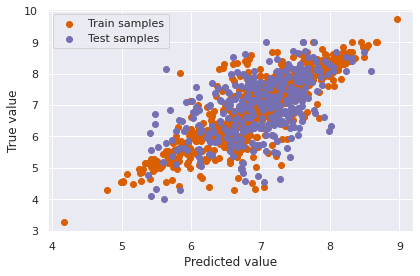

In [ ]:
plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02')
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=test_predictions))

0.6523021292948877


In [ ]:
def calc_fpr_tpr(conf_matrix):
  FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
  FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
  TP = np.diag(conf_matrix)
  TN = conf_matrix.sum() - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  return TPR, FPR


In [ ]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

[0.78014885 0.78014885]


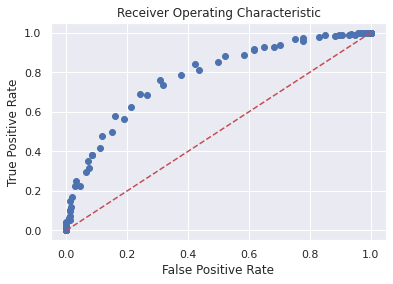

In [ ]:
list_fpr = []
list_tpr = []
for cutoff in np.linspace(-3, 100, 1000):
  label_pred = np.where(test_predictions > cutoff, 1, 0)
  confusion_matrix = sklearn.metrics.confusion_matrix(y_test_class_labels, label_pred)
  tpr, fpr = calc_fpr_tpr(confusion_matrix)
  list_fpr.append(fpr)
  list_tpr.append(tpr)
fig, ax = plt.subplots()
ax.scatter(list_fpr, list_tpr)
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
#ax.legend(loc="lower right")
fig.show()
fpr_for_auc = np.asarray(list_fpr.append(1))
tpr_for_auc = np.asarray(list_tpr.append(0))
auc = PolyArea(list_fpr, list_tpr)
print(auc)

In [ ]:
label_pred = np.where(test_predictions > 6.3, 1, 0)

print(sklearn.metrics.accuracy_score(y_test_class_labels, label_pred))
print(sklearn.metrics.classification_report(y_test_class_labels, label_pred))
print(sklearn.metrics.confusion_matrix(y_test_class_labels, label_pred))


0.7723342939481268
              precision    recall  f1-score   support

           0       0.65      0.35      0.46        94
           1       0.79      0.93      0.86       253

    accuracy                           0.77       347
   macro avg       0.72      0.64      0.66       347
weighted avg       0.75      0.77      0.75       347

[[ 33  61]
 [ 18 235]]


In [ ]:
reader =  pd.read_csv("/content/drive/MyDrive/Discovery_Data/molport_database.csv", chunksize= 1000)
pred_results = []
error_list = []
for i, chunk in enumerate(reader):
    try:
      print(i)
      chunk["fingerprints_df"] = chunk["SMILES"].apply(smiles_to_fp)
      predictions = automl.predict(np.array(list(chunk["fingerprints_df"])))
      pred_results.extend(predictions)
      chunk.head()
    except:
      error_list.append(i)
      print(error_list)
    if i%100 == 99:
      np.save(f"/content/drive/MyDrive/Discovery_Data/predictions_best_model{i}.npy", np.array(pred_results))
    if i == 700:
      np.save("/content/drive/MyDrive/Discovery_Data/predictions_best_model.npy", np.array(pred_results))
      print(error_list)
      break


0
1
2
3
[3]
4
5
6
7
8
9
10
11
12
13
14
15
16
[3, 16]
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
[3, 16, 64]
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
[3, 16, 64, 144]
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
2

In [ ]:
a = np.load("/content/drive/MyDrive/Discovery_Data/predictions_best_model399.npy")
print(a.shape)
print(a[0:10])

(396000,)
[6.81347165 6.64583527 6.64583527 6.91667128 6.93801132 6.93801132
 7.02059722 6.82214294 6.41999856 6.60244586]


In [ ]:
with open('/content/drive/MyDrive/Discovery_Data/automl-reg.pkl', 'rb') as f:
    automl = pickle.load(f)

EOFError: ignored

In [ ]:
# we can do the same in the other dataframe
import pandas as pd
reader =  pd.read_csv("/content/drive/MyDrive/Discovery_Data/KSL_database.csv", chunksize= 3000)
pred_results = []
error_list = []
for i, chunk in enumerate(reader):
   
      chunk["fingerprints_df"] = chunk["SMILES"].apply(smiles_to_fp)
      predictions = automl.predict(np.array(list(chunk["fingerprints_df"])))
      pred_results.extend(predictions)
      chunk.head()

   
      np.save(f"/content/drive/MyDrive/Discovery_Data/predictions_best_model{i}ksl.npy", np.array(pred_results))

      np.save("/content/drive/MyDrive/Discovery_Data/predictions_best_modelksl.npy", np.array(pred_results))

 

In [ ]:
#Choosing the best hits


In [ ]:
molport_results = np.load("/content/drive/MyDrive/Discovery_Data/predictions_best_model399.npy")
molport_faulty_calculations = [3, 16, 64, 144, 269]
best_results_molport = np.argpartition(-molport_results, kth=75)
#print(best_results[0:75])
print(molport_results[best_results[0:75]])
index_of_molport_results = []
for pure_idx in best_results[0:75]:  # because some data was faulty, we need to artificially padden the index
  molport_idx = pure_idx
  for faulty_calc in molport_faulty_calculations:
    if pure_idx > 1000*faulty_calc:
      molport_idx -= 1000
  index_of_molport_results.append(molport_idx)
#print(best_results[0:10])
#print(index_of_molport_results[0:10])
#print(molport_results.shape)
ksl_results = np.load("/content/drive/MyDrive/Discovery_Data/predictions_best_modelksl.npy")
index_of_ksl_results = np.argpartition(-ksl_results, kth=75)
print(index_of_ksl_results[0:10])
print(ksl_results[index_of_ksl_results[0:10]])


[7.99525847 8.09488069 7.9763297  7.96745165 7.9587561  8.0011273
 8.00245383 7.96396901 8.07204522 8.07667752 7.95780113 7.98063715
 8.12102915 7.9917419  7.97495306 8.07204522 7.95243841 8.29174548
 7.95575717 8.04227899 7.94776167 7.89283688 7.8998107  7.91442251
 7.93730798 7.90810157 7.92482018 7.91425928 7.8932884  7.94513267
 7.91472124 7.8849133  7.91279264 7.89645262 7.92436011 7.89092836
 7.92233258 7.91697393 7.93892778 7.89562424 7.9090541  7.89205228
 7.89205228 7.9419104  7.8932884  7.91425928 7.89452049 7.90178692
 7.88553192 7.90532644 7.89531431 7.89283688 7.91425928 7.90117075
 7.91279264 7.92526491 7.88444449 7.9419104  7.89431097 7.90233244
 7.91279264 7.90810157 7.91425928 7.90233244 7.88758494 7.88900371
 7.91513011 7.91472124 7.89343433 7.89283688 7.89141341 7.92233258
 7.88793513 7.93114775 7.88381653]
[2193  901  915  925  927  350  978  877 2694  855]
[7.59036951 7.58545579 7.68413919 7.57153459 7.57153459 7.58972207
 7.59489547 7.79605244 7.61328445 7.6265110

In [ ]:
reader =  pd.read_csv("/content/drive/MyDrive/Discovery_Data/molport_database.csv", chunksize= 1000)
resulting_proteins = pd.DataFrame(columns=['Unnamed: 0', 'ID', 'SMILES', 'Molecule'])
for i, chunk in enumerate(reader):
  #index_list = [0, 12, 23]
  #a = chunk.loc[index_list]
  #print(a)
  #a = chunk[0:3]
  #print(a)
  min_value = i*1000
  max_value = (i+1)*1000
  sub_indices = []
  for index in index_of_molport_results:
    if min_value <= index and index < max_value:
      sub_indices.append(index)
  if len(sub_indices) > 0:
    sub_resulting_proteins = chunk.loc[sub_indices]
    print(sub_resulting_proteins)
    resulting_proteins.append(sub_resulting_proteins)
  if i==399:
    break
print(resulting_proteins)

      Unnamed: 0  ...                                           Molecule
2016        2016  ...  <img data-content="rdkit/molecule" src="data:i...
2315        2315  ...  <img data-content="rdkit/molecule" src="data:i...
2622        2622  ...  <img data-content="rdkit/molecule" src="data:i...
2438        2438  ...  <img data-content="rdkit/molecule" src="data:i...
2634        2634  ...  <img data-content="rdkit/molecule" src="data:i...
2381        2381  ...  <img data-content="rdkit/molecule" src="data:i...
2399        2399  ...  <img data-content="rdkit/molecule" src="data:i...
2460        2460  ...  <img data-content="rdkit/molecule" src="data:i...

[8 rows x 4 columns]
      Unnamed: 0  ...                                           Molecule
9135        9135  ...  <img data-content="rdkit/molecule" src="data:i...
9236        9236  ...  <img data-content="rdkit/molecule" src="data:i...

[2 rows x 4 columns]
       Unnamed: 0  ...                                           Molecule
15328 

In [ ]:
ksl_database = pd.read_csv("/content/drive/MyDrive/Discovery_Data/KSL_database.csv")
resulting_proteins_ksl = ksl_database.loc[index_of_ksl_results[0:75]]
resulting_proteins_ksl

,Unnamed: 0,IDNUMBER,Chemical_Name,CAS,PriceCoeff,MW,Description,FSP3,clogP,TPSA,H-acceptors,H-donors,RotBonds,HAC,Reference,Method,SimilaritySearch,fromRegid,Activity_Type,Activity_Value,Activity_Units,Target_Name,Target_Organism,Target_Type,Assay_Description,ID,SMILES,Molecule,LCTNUMBER
2193,2193,F0614-0067,"2-iodo-N-{4-methyl-5-oxo-5H-chromeno[4,3-b]pyr...",851411-46-6,1.0,456.23,solid,0.05,3.71,68.29,4,2,2,26,Kinase_pharmacophore_model,Screening_Result,0.849,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0614-0067,Cc1cc(NC(=O)c2ccccc2I)nc2c1c(=O)oc1ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00018
901,901,F0614-0066,"2-bromo-N-{4-methyl-5-oxo-5H-chromeno[4,3-b]py...",851411-45-5,1.0,409.23,solid,0.05,3.58,68.29,4,2,2,26,Kinase_pharmacophore_model,Screening_Result,0.846,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0614-0066,Cc1cc(NC(=O)c2ccccc2Br)nc2c1c(=O)oc1ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00018
915,915,F2410-1285,N-(4-fluorophenyl)-3-[2-(trifluoromethyl)benza...,946224-41-5,1.0,443.35,solid,0.05,3.93,84.23,4,3,4,32,Kinase_pharmacophore_model,Screening_Result,ND,ND,ND,ND,ND,ND,ND,ND,ND,F2410-1285,O=C(Nc1c(C(=O)Nc2ccc(F)cc2)oc2cccnc12)c1ccccc1...,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT01662
925,925,F0614-0036,"4-fluoro-N-{4-methyl-5-oxo-5H-chromeno[4,3-b]p...",851411-20-6,1.0,348.33,solid,0.05,3.78,68.29,4,2,2,26,Kinase_pharmacophore_model,Screening_Result,0.872,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0614-0036,Cc1cc(NC(=O)c2ccc(F)cc2)nc2c1c(=O)oc1ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00018
927,927,F0614-0035,"3-fluoro-N-{4-methyl-5-oxo-5H-chromeno[4,3-b]p...",851411-19-3,1.0,348.33,solid,0.05,3.78,68.29,4,2,2,26,Kinase_pharmacophore_model,Screening_Result,0.872,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0614-0035,Cc1cc(NC(=O)c2cccc(F)c2)nc2c1c(=O)oc1ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,1937,F0666-0299,3-(3-chlorobenzamido)-N-(3-methoxyphenyl)-1-be...,887894-23-7,1.0,420.85,solid,0.04,5.17,80.57,4,2,5,30,Kinase_pharmacophore_model,Screening_Result,0.791,CHEMBL1565318,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0666-0299,COc1cccc(NC(=O)c2oc3ccccc3c2NC(=O)c2cccc(Cl)c2)c1,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00070
1240,1240,F0666-0173,3-(2-chlorobenzamido)-N-(2-methoxyphenyl)-1-be...,887890-98-4,1.0,420.85,solid,0.04,3.75,80.57,4,2,5,30,Kinase_pharmacophore_model,Screening_Result,0.815,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0666-0173,COc1ccccc1NC(=O)c1oc2ccccc2c1NC(=O)c1ccccc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00070
2706,2706,F0666-0433,"3-(2,5-dichlorobenzamido)-N-(4-methoxyphenyl)-...",887872-54-0,1.0,455.29,solid,0.04,5.08,80.57,4,2,5,31,Kinase_pharmacophore_model,Screening_Result,0.753,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dose response biochemical sc...,F0666-0433,COc1ccc(NC(=O)c2oc3ccccc3c2NC(=O)c2cc(Cl)ccc2C...,"<img data-content=""rdkit/molecule"" src=""data:i...",LCT00070
1940,1940,F0666-0423,3-(2-chlorobenzamido)-N-(4-methoxyphenyl)-1-be...,887871-83-2,1.0,420.85,solid,0.04,4.34,80.57,4,2,5,30,Kinase_pharmacophore_model,Screening_Result,0.775,CHEMBL1614549,IC50,9896,nM,c-Jun N-terminal kinase 3,Homo sapiens,SINGLE PROTEIN,PUBCHEM_BIOASSAY: Dos

FILTERING BY ADMET PROPERTIES

The bioavailability of a compound is an important ADME property. Lipinski’s rule of five (Ro5, Adv. Drug Deliv. Rev. (1997), 23, 3-25) was introduced to estimate the bioavailability of a compound solely based on its chemical structure. The Ro5 states that poor absorption or permeation of a compound is more probable if the chemical structure violates more than one of the following rules:

Molecular weight (MWT) <= 500 Da

Number of hydrogen bond acceptors (HBAs) <= 10

Number of hydrogen bond donors (HBD) <= 5

Calculated LogP (octanol-water coefficient) <= 5

Note: All numbers in the Ro5 are multiples of five; this is the origin of the rule’s name.

Additional remarks:

LogP is also called partition coefficient or octanol-water coefficient. It measures the distribution of a compound, usually between a hydrophobic (e.g. 1-octanol) and a hydrophilic (e.g. water) phase.

Hydrophobic molecules might have a reduced solubility in water, while more hydrophilic molecules (e.g. high number of hydrogen bond acceptors and donors) or large molecules (high molecular weight) might have more difficulties in passing phospholipid membranes.

In [ ]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [ ]:
#Load best hits with the id and the smiles and the prediction
best_hits = resulting_proteins_ksl[['IDNUMBER', 'SMILES']]

## Calculate and plot molecular properties for Ro5 (Rule of five)

In [ ]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) >= 5
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA", "ro5_fulfilled"],
    )

In [ ]:
# Calculate RO5 properties
ro5_properties = best_hits["SMILES"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
2193,455.997090,4,1,4.50652,72.20,True
901,408.010954,4,1,4.66442,72.20,True
915,443.089304,4,2,5.49030,84.23,False
925,348.091020,4,1,4.04102,72.20,True
927,348.091020,4,1,4.04102,72.20,True


In [ ]:
MoleculeDatabase = pd.concat([best_hits, ro5_properties], axis=1)
MoleculeDatabase.head()

,IDNUMBER,SMILES,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
2193,F0614-0067,Cc1cc(NC(=O)c2ccccc2I)nc2c1c(=O)oc1ccccc12,455.997090,4,1,4.50652,72.20,True
901,F0614-0066,Cc1cc(NC(=O)c2ccccc2Br)nc2c1c(=O)oc1ccccc12,408.010954,4,1,4.66442,72.20,True
915,F2410-1285,O=C(Nc1c(C(=O)Nc2ccc(F)cc2)oc2cccnc12)c1ccccc1...,443.089304,4,2,5.49030,84.23,False
925,F0614-0036,Cc1cc(NC(=O)c2ccc(F)cc2)nc2c1c(=O)oc1ccccc12,348.091020,4,1,4.04102,72.20,True
927,F0614-0035,Cc1cc(NC(=O)c2cccc(F)c2)nc2c1c(=O)oc1ccccc12,348.091020,4,1,4.04102,72.20,True


In [ ]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
MoleculeDatabase_ro5_fulfilled = MoleculeDatabase[MoleculeDatabase["ro5_fulfilled"]]
MoleculeDatabase_ro5_violated = MoleculeDatabase[~MoleculeDatabase["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {MoleculeDatabase.shape[0]}")
print(f"# compounds in filtered data set: {MoleculeDatabase_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {MoleculeDatabase_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 75
# compounds in filtered data set: 28
# compounds not compliant with the Ro5: 47


In [ ]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [ ]:
MoleculeDatabase_ro5_fulfilled_stats = calculate_mean_std(
    MoleculeDatabase_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA"]]
)
MoleculeDatabase_ro5_fulfilled_stats

,mean,std
molecular_weight,377.603118,52.597590
n_hba,4.857143,1.112697
n_hbd,1.321429,0.547964
logp,3.879177,1.241211
TPSA,90.186786,19.274344


In [ ]:
MoleculeDatabase_ro5_violated_stats = calculate_mean_std(
    MoleculeDatabase_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA"]]
)
MoleculeDatabase_ro5_violated_stats

,mean,std
molecular_weight,441.002821,25.717782
n_hba,4.893617,1.386802
n_hbd,1.914894,0.282057
logp,5.202046,1.586094
TPSA,94.282340,20.472924


In [ ]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [ ]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [ ]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 6, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [ ]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5, "TPSA":140}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
    "TPSA / 28"
]
y_max = 8

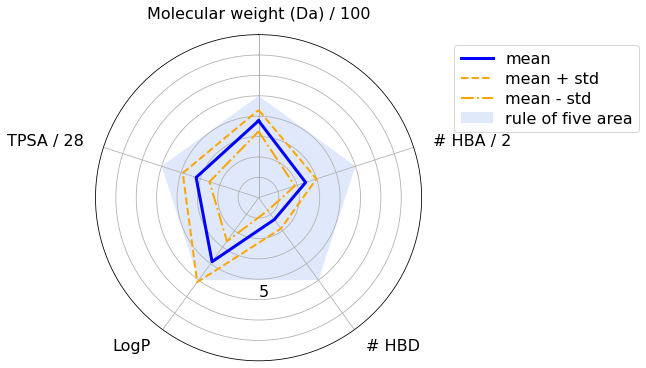

In [ ]:
plot_radar(
    MoleculeDatabase_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

In [ ]:
plot_radar(
    MoleculeDatabase_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=3)
MoleculeDatabase_ro5_fulfilled.hist(["molecular_weight"], ax=axes[0, 0])
MoleculeDatabase_ro5_fulfilled.hist(["n_hba"], ax=axes[0, 1])
MoleculeDatabase_ro5_fulfilled.hist(["n_hbd"], ax=axes[1, 0])
MoleculeDatabase_ro5_fulfilled.hist(["logp"], ax=axes[1, 1])
MoleculeDatabase_ro5_fulfilled.hist(["TPSA"], ax=axes[0, 2])


,IDNUMBER,SMILES,Molecule,MoleculeH
143,F3147-4028,O=C(Nc1ccccc1)Nc1ccccn1,,
350,F6617-6305,COc1ccc2nc(C(=O)Nc3ccc(OC)c(OC)c3)cc(OC)c2c1,,
455,F0191-2972,CN(C)c1ccc(C=C2C(=O)NC(=O)NC2=O)cc1[N+](=O)[O-],,
532,F0614-0048,Cc1cc(NC(=O)c2ccc(Br)o2)nc2c1c(=O)oc1ccccc12,,
541,F0245-0029,CC(=O)n1cc(C=C2C(=O)NC(=O)NC2=O)c2ccccc21,,
545,F3324-0214,CN1C(=O)C(=Cc2cc3c(cc2[N+](=O)[O-])OCO3)C(=O)N...,,
581,F3181-0321,O=C(NC(=O)c1ccccc1)Nc1ccc(Cl)cn1,,
855,F2410-0990,O=C(Nc1c(C(=O)Nc2ccccc2F)oc2cccnc12)c1ccccc1F,,
877,F2410-0585,COc1ccccc1NC(=O)c1oc2cccnc2c1NC(=O)c1ccccc1F,,
901,F0614-0066,Cc1cc(NC(=O)c2ccccc2Br)nc2c1c(=O)oc1ccccc12,,

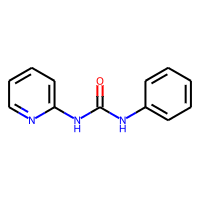
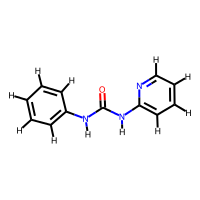
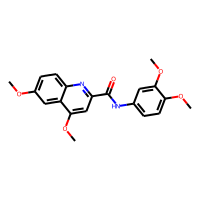
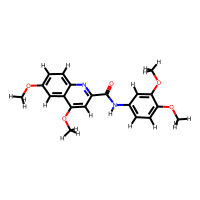
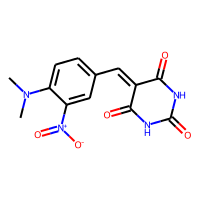
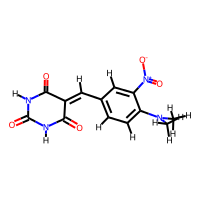
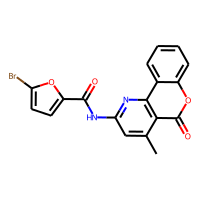
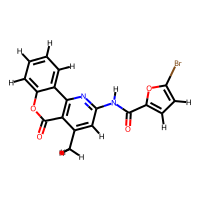
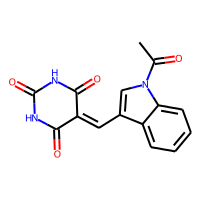
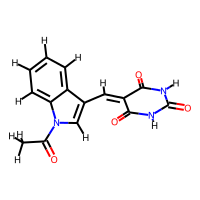
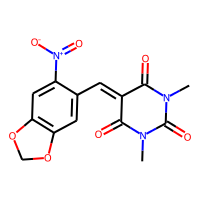
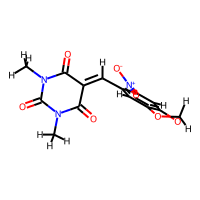
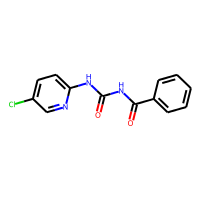
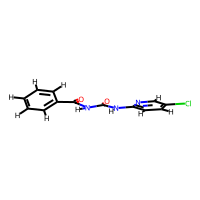
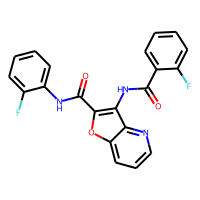
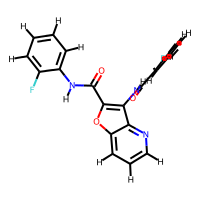
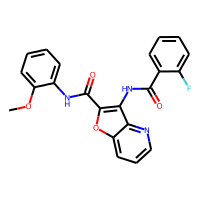
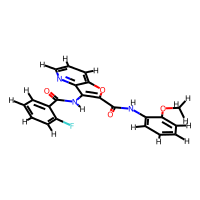
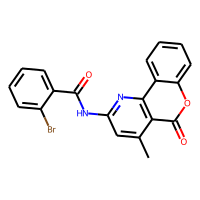
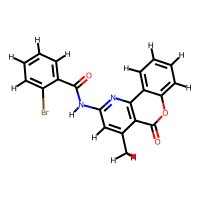
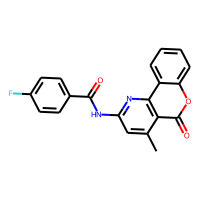
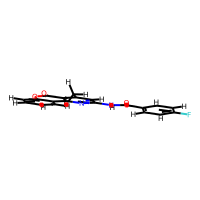
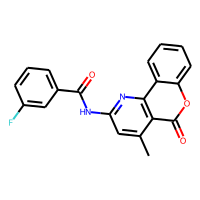
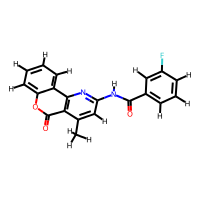
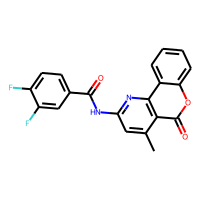
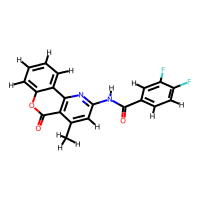
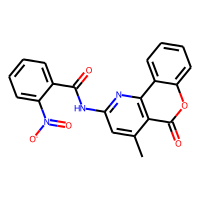
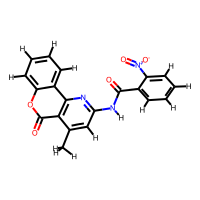
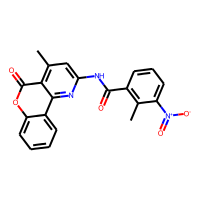
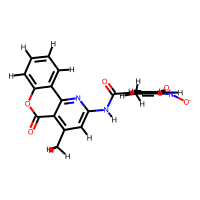
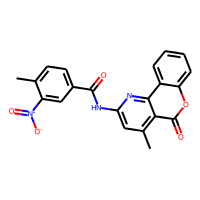
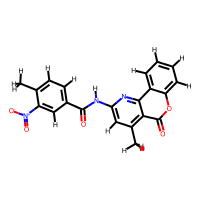
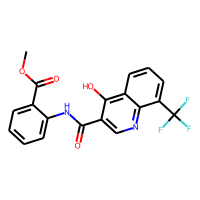
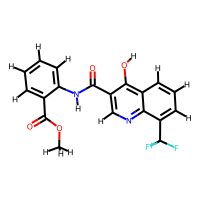
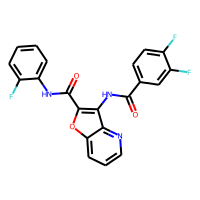
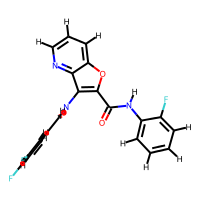
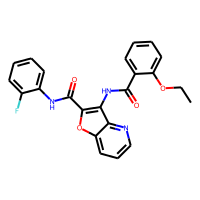
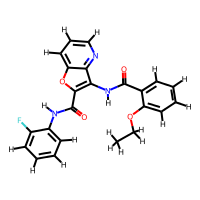
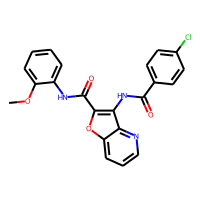
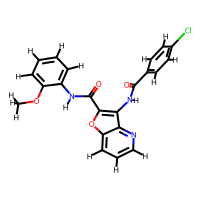
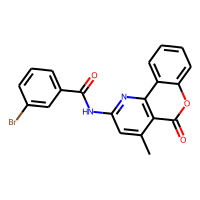
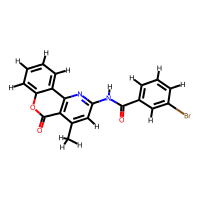
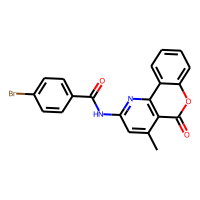
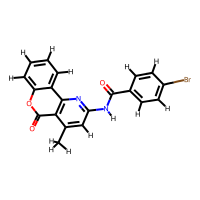
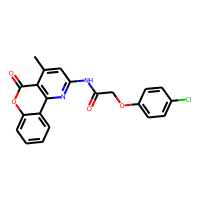
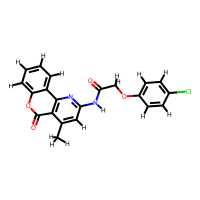
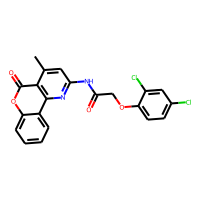
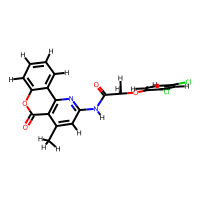
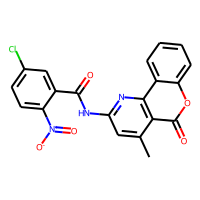
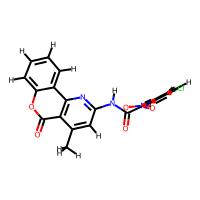
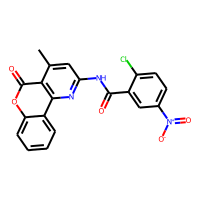
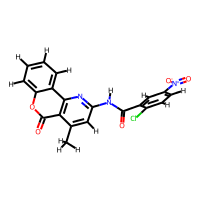
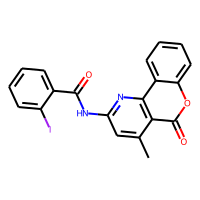
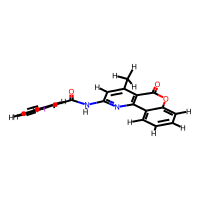
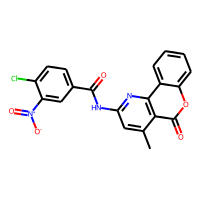
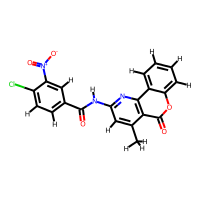

In [ ]:
# Save filtered data
MoleculeDatabase_ro5_fulfilled.to_csv("MoleculeDatabase_compounds_lipinski.csv")
MoleculeDatabase_ro5_fulfilled.sort_index()

In [ ]:
MoleculeDatabase_ro5_fulfilled = MoleculeDatabase_ro5_fulfilled[['IDNUMBER', 'SMILES']]
PandasTools.AddMoleculeColumnToFrame(MoleculeDatabase_ro5_fulfilled,'SMILES','Molecule')
MoleculeDatabase_ro5_fulfilled['MoleculeH'] = MoleculeDatabase_ro5_fulfilled['Molecule'].apply(Chem.AddHs)
MoleculeDatabase_ro5_fulfilled['MoleculeH'].map(AllChem.EmbedMolecule)
PandasTools.WriteSDF(MoleculeDatabase_ro5_fulfilled, 'DrugDatabase.sdf', molColName='MoleculeH', properties=list(MoleculeDatabase_ro5_fulfilled.columns))

The next section wasn't used because the environment and the installation required didn't work after many trys. For this reason MTiAutoDock1.0 was used.

FROM THE FILTERED MOLECULES TAKE THE 5 BEST HITS FOR DO DOCKING

In [ ]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(rdBase.rdkitVersion)

2021.09.3


In [ ]:
!pip install https://github.com/volkamerlab/opencadd/archive/master.tar.gz
!pip install mdanalysis

  Using cached https://github.com/volkamerlab/opencadd/archive/master.tar.gz


In [ ]:
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab numpy pandas scipy matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields opencadd
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()
!conda activate openmm

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
--2022-01-10 20:54:09--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M   136MB/s    in 0.6s    

2022-01-10 20:54:10 (136 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | failed with repodata from current_repodata.json, wil

In [ ]:
!conda install mdanalysis

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mdanalysis


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.79             |   py39h3811e60_1         2.6 MB  conda-forge
    cftime-1.5.1.1             |   py39hce5d2b2_1         242 KB  conda-forge
    curl-7.78.0                |       h1ccab

In [ ]:
!pip uninstall numpy
!pip install numpy==1.20.0

Found existing installation: numpy 1.22.0


In [ ]:
# import libraries
import warnings
from pathlib import Path
import subprocess

import nglview as nv
from openbabel import pybel

from opencadd.structure.core import Structure

ValueError: ignored

In [ ]:
# filter warnings
warnings.filterwarnings("ignore")
ob_log_handler = pybel.ob.OBMessageHandler()
pybel.ob.obErrorLog.SetOutputLevel(0)

In [ ]:
# preparation of the protein and the ligands
pdb_id = "6XV9"
structure = Structure.from_pdbid(pdb_id)
# element information maybe missing, but important for subsequent PDBQT conversion
if not hasattr(structure.atoms, "elements"):
    structure.add_TopologyAttr("elements", structure.atoms.types)
structure

In [ ]:
# write the protein file to disk
protein = structure.select_atoms("protein")
protein.write("/content/drive/MyDrive/Discovery_Data/protein.pdb")

In [ ]:
def pdb_to_pdbqt(pdb_path, pdbqt_path, pH=7.4):
    """
    Convert a PDB file to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    pdb_path: str or pathlib.Path
        Path to input PDB file.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = list(pybel.readfile("pdb", str(pdb_path)))[0]
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    return

In [ ]:
pdb_to_pdbqt("/content/drive/MyDrive/Discovery_Data/protein.pdb", "/content/drive/MyDrive/Discovery_Data/protein.pdbqt")

In [ ]:
# Prepare the ligands 
# list of smiles of the hits that have the properties admet I want and acomplish RO5
smiles=[]

In [ ]:
out=pybel.Outputfile(filename='/content/drive/MyDrive/Discovery_Data/InputMols.mol2',format='mol2',overwrite=True)
for index,smi in enumerate(smiles):
    mol=pybel.readstring(string=smi,format='smiles')
    mol.title='mol_'+str(index)
    mol.make3D('mmff94s')
    mol.localopt(forcefield='mmff94s', steps=500)
    out.write(mol)
out.close()